In [124]:
import sys, time, os
from pathlib import Path
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from bmi_topography import Topography
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid
from landlab.components import FlowAccumulator, PriorityFloodFlowRouter, ChannelProfiler, BedrockLandslider, SpaceLargeScaleEroder
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab.io.netcdf import read_netcdf
from landlab.utils import get_watershed_mask

# [SPACE large-scale](https://landlab.readthedocs.io/en/latest/reference/components/space.html#module-landlab.components.space.space_large_scale_eroder)

In [125]:
# import small DEM
topo = Topography(
    dem_type="SRTMGL1",
    south=43.971911,
    north=43.982382,
    west=-123.826646,
    east=-123.813606,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )
fname = topo.fetch()
dem = topo.load()
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')    

In [126]:
grid = RasterModelGrid ((grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), 30) # 30 meters
grid.add_field('topographic__elevation', elev, at = 'node')

num_rows, num_columns = grid.shape 
node_spacing = grid.dx

In [127]:
node_next_to_outlet = num_columns + 1
np.random.seed(seed=5000)

_ = grid.add_zeros("soil__depth", at="node")
grid.at_node["soil__depth"][grid.core_nodes] = 2.0

# why do we divide by 10?
_ = grid.add_zeros("bedrock__elevation", at="node")
grid.at_node["bedrock__elevation"] += (
    grid.node_y / 10. + grid.node_x / 10. + np.random.rand(len(grid.node_y)) / 10.
)
grid.at_node["bedrock__elevation"][:] = grid.at_node["topographic__elevation"]
grid.at_node["topographic__elevation"][:] += grid.at_node["soil__depth"]

grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True,
    left_is_closed=True,
    right_is_closed=True,
    top_is_closed=True,
)

grid.set_watershed_boundary_condition_outlet_id(
    0, grid.at_node['topographic__elevation'], -9999.0
)

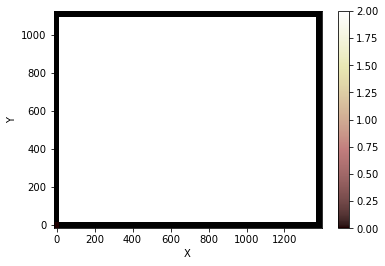

In [128]:
_ = imshow_grid(grid, "soil__depth")

In [129]:
flood_router = PriorityFloodFlowRouter(grid, flow_metric='D8', suppress_out = True)
space = SpaceLargeScaleEroder(
    grid,
    K_sed=0.01, # erodibility for sediment
    K_br=0.001, # erodibility for bedrock
    F_f=0.0, # 
    phi=0.0,
    H_star=1.0,
    v_s=5.0,
    m_sp=0.5,
    n_sp=1.0,
    sp_crit_sed=0,
    sp_crit_br=0,
)

In [130]:
timestep = 10.0
elapsed_time = 0.0
count = 0
run_time = 1e3
sed_flux = np.zeros(int(run_time // timestep))

In [131]:
while elapsed_time < run_time:
    flood_router.run_one_step()
    _ = space.run_one_step(dt=timestep)
    sed_flux[count] = grid.at_node["sediment__flux"][node_next_to_outlet]
    elapsed_time += timestep
    count += 1

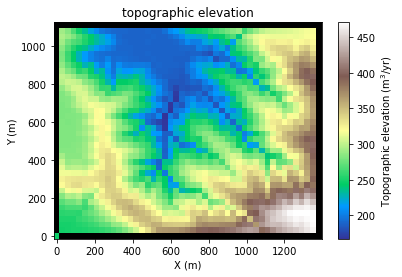

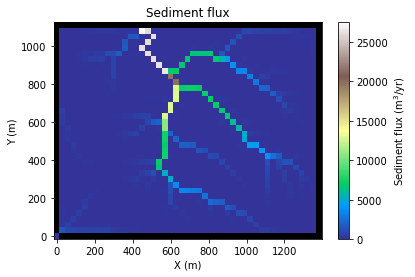

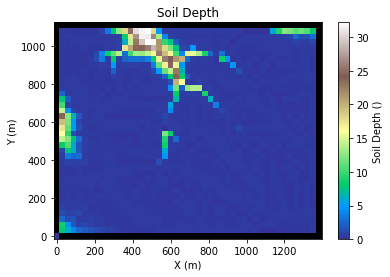

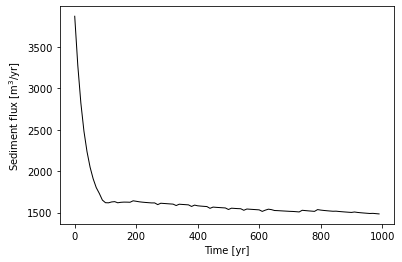

In [132]:
fig = plt.figure()
plot = plt.subplot()
_ = imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="topographic elevation",
    var_name="Topographic elevation",
    var_units=r"m$^3$/yr",
    grid_units=("m", "m"),
    cmap="terrain",
)
_ = plt.figure()

_ = imshow_grid(
    grid,
    "sediment__flux",
    plot_name="Sediment flux",
    var_name="Sediment flux",
    var_units=r"m$^3$/yr",
    grid_units=("m", "m"),
    cmap="terrain",
)
fig = plt.figure()

_ = imshow_grid(
    grid,
    "soil__depth",
    plot_name="Soil Depth",
    var_name="Soil Depth",
    var_units=r"",
    grid_units=("m", "m"),
    cmap="terrain",
)
fig = plt.figure()

sedfluxplot = plt.subplot()
_ = sedfluxplot.plot(np.arange(len(sed_flux)) * timestep, sed_flux, color="k", linewidth=1.0)
_ = sedfluxplot.set_xlabel("Time [yr]")
_ = sedfluxplot.set_ylabel(r"Sediment flux [m$^3$/yr]")

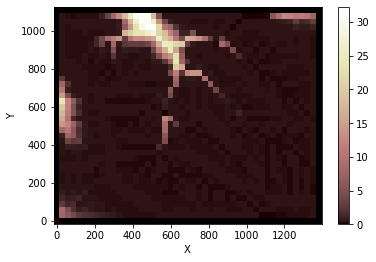

In [133]:
_ = imshow_grid(grid, "soil__depth")